In [1]:
import os

import pandas as pd
import numpy as np
from tqdm.auto import tqdm  # for notebooks
import matplotlib.pyplot as plt
# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [2]:
def choose_target_period(pat, mins_before_first_icp=60 * 24, target_name="ICP_Vital",
                         min_val=-10, max_val=105):
    target_steps = pat[pat["Maßnahme"] == target_name]
    no_outlier_mask = (target_steps["Wert"] >= min_val) & (target_steps["Wert"] <= max_val)
    target_steps = target_steps[no_outlier_mask]
    # kick out targets beyond thresholds
    if len(target_steps) == 0:
        return pat.iloc[0:0]
    min_target_time = min(target_steps["rel_time"])
    min_allowed_time = min_target_time - mins_before_first_icp
    max_target_time = max(target_steps["rel_time"])
    # kick out (basically set to NaN) measurements beyond interesting region
    pat = pat[pat["rel_time"] >= min_allowed_time]
    pat = pat[pat["rel_time"] <= max_target_time]
    # adjust rel_time
    pat["rel_time"] -= min(pat["rel_time"])
    return pat

In [18]:
load_icp = True

if load_icp:
    df_long = pd.read_csv("data/Datenbank_icp.csv")
    if "Unnamed: 0" in df_long:
        df_long = df_long.drop(columns=["Unnamed: 0"])
else:
    df_long = pd.read_csv("data/Datenbank_Werte.csv")
    print("Loaded data")
    # drop eICU
    #df_long = df_long[df_long["DB"] != "eICU"]
    
    # add type to Maßnahme
    df_long["Maßnahme"] += "_" + df_long["ID"]
    df_long = df_long.drop(columns="ID")

    # drop measurements where we have a "NAN"
    print("Drop NaN measurements")
    df_long = df_long.dropna(subset=["Wert"])
    
    # drop duplicates
    print("Dropping duplicates...")
    df_long = df_long.drop_duplicates(subset=["Pat_ID", "Maßnahme", "rel_time", "Wert"])
    
    # fix rel_times to ICP, drop steps after last ICP measurement, filter ICP outliers
    # use 0.999 quantile = -10 to 105
    print("Fixing ICP times...")
    df_long = df_long.groupby("Pat_ID").apply(lambda pat: 
                                choose_target_period(pat, mins_before_first_icp=60 * 24, 
                                                     target_name="ICP_Vital",
                                                     min_val=-10, max_val=105))
    df_long = df_long.reset_index(drop=True)

    # merge "NBD" (non-invasive ways of measuring blood pressure) with invasive ways as they measure the same thing
    print("Merging NBD...")
    def rename_nbd(name):
        if "syst" in name:
            name = "syst_Vital"
        elif "diast" in name:
            name = "diast_Vital"
        elif "mittl" in name:
            name = "mittl_Vital"
        return name
    df_long["Maßnahme"] = df_long["Maßnahme"].apply(rename_nbd)
    
    df_long.to_csv("data/Datenbank_icp.csv", index=False)
    
    # save maßnahme and maßnahme norm for meds
    measures_norm_groups = df_long.groupby("Maßnahme")
    mapping_dict = {}
    for group_name, group in measures_norm_groups:
        if "_Med" in group_name:
            measures = list(group["Maßnahme_norm"].unique())
            mapping_dict[group_name] = measures
    # save mapping dict
    import json
    with open("data/measure_norm_mapping_dict.json", "w") as f:
        json.dump(mapping_dict, f)
print("Data loaded!")

/tmp/ipykernel_1638321/1207230546.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_long = pd.read_csv("data/Datenbank_icp.csv")


Data loaded!


array(['Ca_BGA', 'Cl_BGA', 'FiO2_BGA', 'Glu_BGA', 'Hb_BGA_BGA',
       'HCO3_BGA', 'K_BGA', 'Na_BGA', 'PCO2_BGA', 'pH_BGA', 'PO2_BGA',
       'sO2_BGA', 'aPTT_Labor', 'Erythrocyten_Labor', 'EVB_Labor',
       'Harnstoff-N_Labor', 'Hk_Labor', 'INR_Labor', 'Kreatinin_Labor',
       'Leukocyten_Labor', 'Lymphocyten_Labor', 'Magnesium_Labor',
       'MCH_Labor', 'MCHC_Labor', 'MCV_Labor', 'Monocyten_Labor',
       'Neutrophile_Labor', 'Thrombocyten_Labor', 'TZ_Labor', 'AF_Vital',
       'CPP_Vital', 'diast_Vital', 'FiO2_Vital', 'Freq gesamt_Vital',
       'GCS_total_Vital', 'HF_Vital', 'ICP_Vital', 'mittl_Vital',
       'PEEP_Vital', 'SpO2_Vital', 'syst_Vital', 'Temp_Vital', 'Bili_BGA',
       'SBE_BGA', 'Albumin_Labor', 'Alk_Labor', 'ALT_Labor', 'AST_Labor',
       'Basophile_Labor', 'Cholesterin_Labor', 'Eosinophile_Labor',
       'Phosphat_Labor', 'Triglyceride_Labor', 'CK_Labor', 'CK-MB_Labor',
       'Troponin_Labor', 'TSH_Labor', 'Lac_BGA', 'LDH_Labor',
       'Lipase_Labor', 'pankre

In [4]:
df_long

,Pat_ID,Maßnahme,Maßnahme_norm,rel_time,Wert,DB
0,141800,Ca_BGA,Ca,540.0,8.500000,eICU
1,141800,Ca_BGA,Ca,1060.0,8.000000,eICU
2,141800,Cl_BGA,Cl,540.0,107.000000,eICU
3,141800,Cl_BGA,Cl,1060.0,115.000000,eICU
4,141800,FiO2_BGA,FO2,74.0,100.000000,eICU
...,...,...,...,...,...,...
108653404,99863_100749,Narkotikum_Med,Propofol,18056.0,20.224083,MIMIC
108653405,99863_100749,Narkotikum_Med,Propofol,18057.0,20.224083,MIMIC
108653406,99863_100749,Narkotikum_Med,Propofol,18058.0,20.224083,MIMIC
108653407,99863_100749,Narkotikum_Med,Propofol,18059.0,20.224083,MIMIC


In [ ]:
df_long.DB.unique()

array(['eICU', 'UKE', 'MIMIC'], dtype=object)

In [ ]:
# determine columns that have few missings - add min, max, std for those
val_counts = df_long.groupby("DB").apply(lambda db: db.groupby("Maßnahme").apply(lambda m: len(m))).reset_index(drop=False)
val_counts = val_counts.groupby("Maßnahme").mean()[0]
val_counts

Maßnahme
AF_Vital              1.091507e+06
ALT_Labor             2.728667e+03
AST_Labor             2.689333e+03
Albumin_Labor         2.496000e+03
Alk_Labor             1.782000e+03
                          ...     
mittl_Vital           7.248710e+05
pH_BGA                4.617500e+04
pankreasspez_Labor    7.060000e+02
sO2_BGA               4.103967e+04
syst_Vital            7.223233e+05
Name: 0, Length: 81, dtype: float64

In [ ]:
# select high count vitals 
quant = 200000 # chosen such that ICP and everything more frequent than it stays in #np.quantile(val_counts, 0.85)
print(quant)
mask = (val_counts > quant).astype(int) + val_counts.index.str.contains("_Vital").astype(int) #+  (~val_counts.index.str.contains("ICP")).astype(int)
mask = mask == 2
high_counts = val_counts[mask].sort_values(0)
print(high_counts)
high_counts = list(high_counts.index) + ["ICP_Vital"]

200000
Maßnahme
Temp_Vital     3.066893e+05
CPP_Vital      5.330533e+05
diast_Vital    7.214337e+05
syst_Vital     7.223233e+05
mittl_Vital    7.248710e+05
ICP_Vital      1.061339e+06
SpO2_Vital     1.078817e+06
AF_Vital       1.091507e+06
HF_Vital       1.130687e+06
Name: 0, dtype: float64


/tmp/ipykernel_2839263/3627366531.py:6: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only.
  high_counts = val_counts[mask].sort_values(0)


In [ ]:
check_dupls = False

if check_dupls:
    for db in df_long.DB.unique():
        df_long_db = df_long[df_long["DB"] == db]
        first_5_vals = df_long_db.groupby("Pat_ID").apply(lambda pat: pat.sort_values("rel_time")["rel_time"].iloc[:5]).reset_index()
        arrays = []
        for pat_id in first_5_vals.Pat_ID.unique():
            array = first_5_vals[first_5_vals.Pat_ID == pat_id].values
            arrays.append(array)
            
        s = []
        for arr in arrays:
            s.append(tuple(arr.reshape(-1).astype(float).round(0)))
        s = set(s)
        
        if len(s) == len(arrays):
            print("No duplicates in " + db)

In [ ]:
icp_vals = df_long[df_long["Maßnahme"] == "ICP_Vital"].reset_index()
diffs = icp_vals.groupby("Pat_ID").apply(lambda pat: pat.sort_values("rel_time")["rel_time"].diff()).reset_index(drop=True)

1555249 1 382


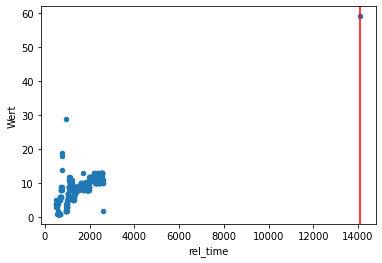

1580483 300 15


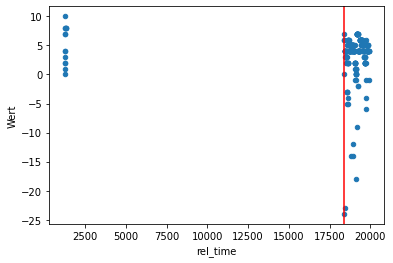

2239718 1207 1689


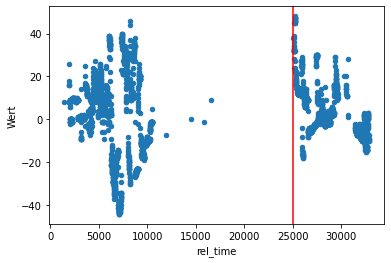

2515333 51 1215


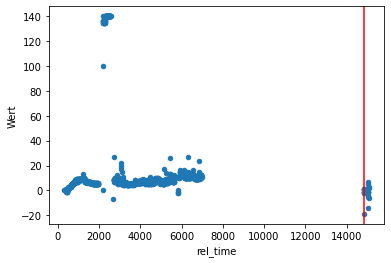

3218440 14 1155


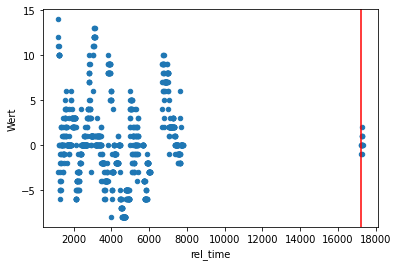

3227651 8088 3574


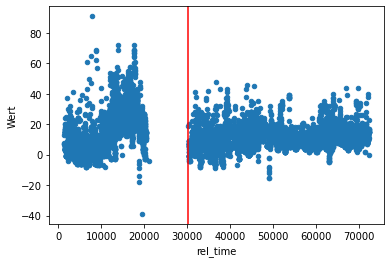

494277745 128 89


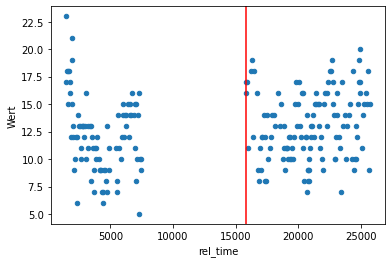

495108527 11 1


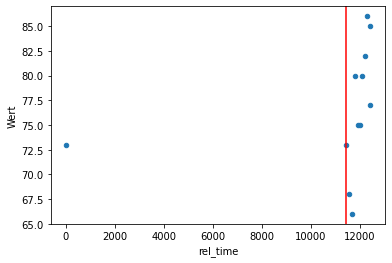

504657169 50 637


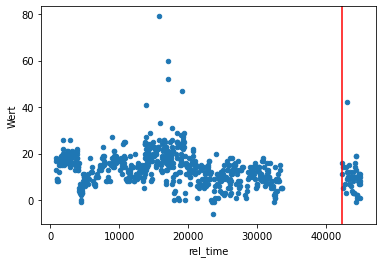

504991188 76 16


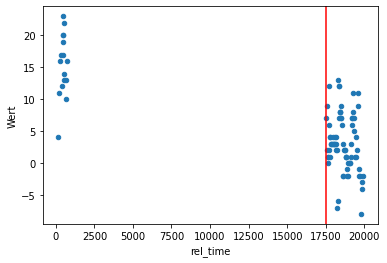

514963989 126 8


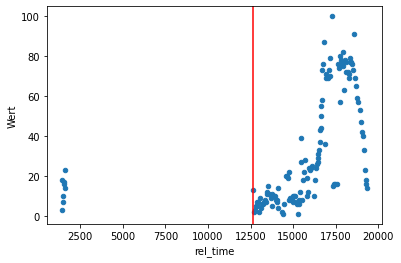

535380365 430 90


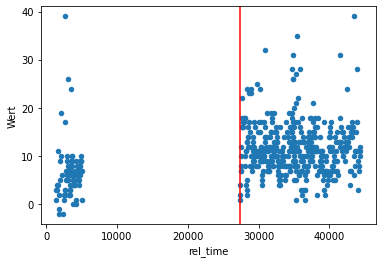

544413324 400 470


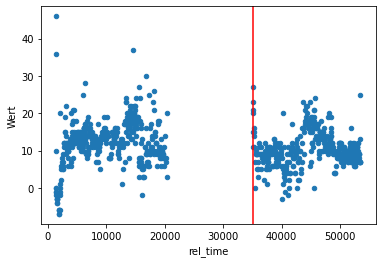

564047304 454 75


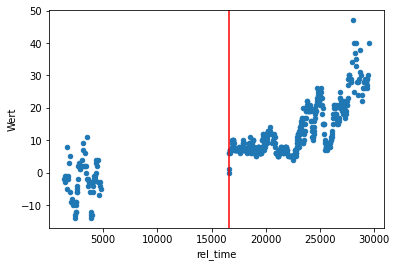

573864154 114 118


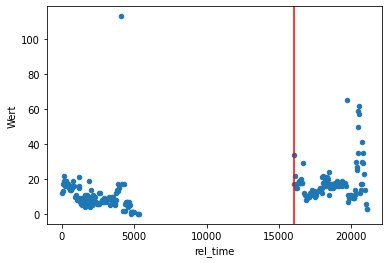

583330420 1 153


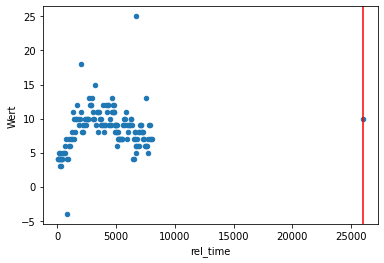

586712988 285 230


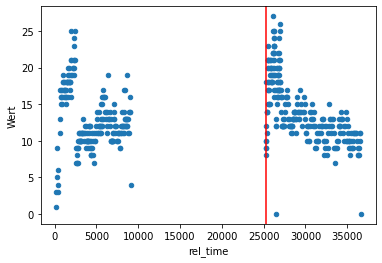

22882_110485 212 514


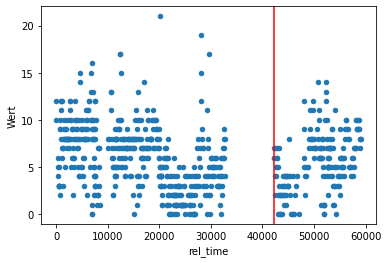

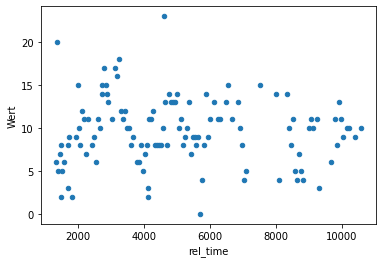

72908_176846 195 380


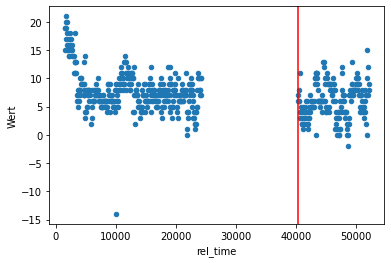

76012_169151 1 84


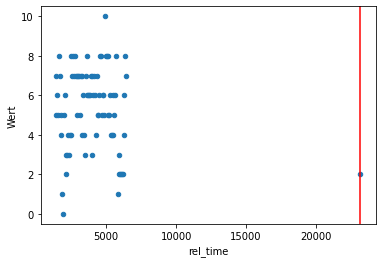

9837_148986 62 18


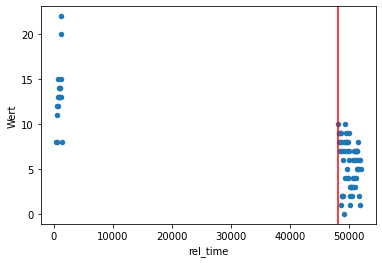

In [ ]:
max_diff = 128 * 60

large_diff_ids = icp_vals[diffs > max_diff].Pat_ID.unique()
for pat_id in large_diff_ids:
    pat_vals = icp_vals[icp_vals["Pat_ID"] == pat_id]
    plt.figure()
    ax = plt.gca()
    pat_diffs = pat_vals.rel_time.diff()
    large_diffs = pat_diffs[pat_diffs > max_diff].reset_index()["rel_time"]
    times_of_diffs = pat_vals[pat_diffs > max_diff].reset_index()["rel_time"]
    for large_diff_time, difference in zip(times_of_diffs, large_diffs):
        # plot vertical line at time
        plt.axvline(large_diff_time, color="red")
        num_vals_above = sum(pat_vals["rel_time"] >= large_diff_time)
        num_vals_below = sum(pat_vals["rel_time"] < large_diff_time)
        print(pat_id, num_vals_above, num_vals_below)
    
    pat_vals.plot(x="rel_time", y="Wert", kind="scatter", ax=ax)
    plt.show()

In [ ]:
# we see many regions where no ICP is measured at all. We can remove those and only take into account the regions where ICP is measured (+ 24 hours before)
max_time_diff = 127 * 60
min_size = 2
time_before_icp = 24 * 60

num_windows = []

def cut_into_windows(pat_data, icp_times, icp_time_diffs):
    times_of_large_diffs = icp_times[icp_time_diffs > max_time_diff]
    if len(times_of_large_diffs) == 0:
        pat_data["window_id"] = 0
        return [pat_data]
    
    # now we have the sorted times of large diffs
    # we want to split regions in two: before and after. If a region is too small, we can remove it
    last_time = 0
    time_windows = []
    for time in times_of_large_diffs:
        # get the time of the ICP measurement before the large diff
        measure_time_before = icp_times[icp_times < time][-1]
        # get the region between the last time and the measurement before the large diff
        before = icp_times[(icp_times <= measure_time_before) & (icp_times >= last_time)]
        if len(before) >= min_size:
            time_windows.append((last_time, measure_time_before))
        last_time = time - time_before_icp
            
    final_part = icp_times[icp_times >= last_time]
    if len(final_part) >= min_size:
        time_windows.append((last_time, final_part[-1]))
    
    windows = []
    for idx, (start, end) in enumerate(time_windows):
        pat_window = pat_data[(pat_data["rel_time"] >= start) & (pat_data["rel_time"] <= end)]
        pat_window["window_id"] = idx
        windows.append(pat_window)
    return windows

df_long_copy = df_long.copy()
pats = []
pat_groups = df_long.groupby("Pat_ID")
for pat_id, pat_data in tqdm(pat_groups):
    # delete pat_mask'ed from df_long_copy to speed up processing for next pat_ids
    #df_long_copy = df_long_copy[~pat_mask]
    # get icp measurements for pat
    icp_measurements = pat_data[pat_data["Maßnahme"] == "ICP_Vital"]
    icp_times = icp_measurements.rel_time.values
    icp_time_diffs = icp_measurements.rel_time.diff()
    # cut into windows
    windows = cut_into_windows(pat_data, icp_times, icp_time_diffs)
    pats.extend(windows)
            
df_long_windows = pd.concat(pats)

  0%|          | 0/3746 [00:00<?, ?it/s]

/tmp/ipykernel_2839263/3143243683.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pat_window["window_id"] = idx
/tmp/ipykernel_2839263/3143243683.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pat_window["window_id"] = idx
/tmp/ipykernel_2839263/3143243683.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [ ]:
#df_long_windows.to_parquet("data/df_long_windows.csv")

In [ ]:
# compare df_long and df_long_windows 
print(len(df_long) - len(df_long_windows))
# compare number of ICP measurements in df_long and df_long_windows
print(len(df_long[df_long["Maßnahme"] == "ICP_Vital"]) - len(df_long_windows[df_long_windows["Maßnahme"] == "ICP_Vital"]))
print(df_long_windows.groupby("DB").apply(lambda db: len(db[db["Maßnahme"] == "ICP_Vital"])))

513839
4
DB
MIMIC     189574
UKE       368183
eICU     2626257
dtype: int64


In [ ]:
import pandas as pd

#df_long_windows = pd.read_csv("data/df_long_windows.csv")

<AxesSubplot:>

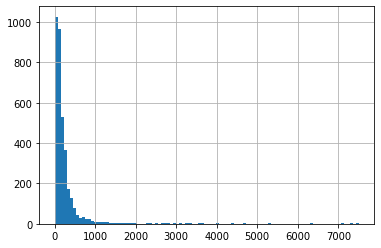

In [ ]:
# check windows lenghts! longest should be at most 60 (minutes) * 128 (hours) = 7680 minutes
df_long_windows.groupby("Pat_ID").apply(lambda x: x.groupby("window_id").apply(lambda win: win[win["Maßnahme"] == "ICP_Vital"].rel_time.diff().max())).hist(bins=100)

In [ ]:
df_long = df_long_windows

In [ ]:
df_long_windows.groupby("DB").apply(lambda db: db.value_counts("window_id"))

window_id,0,1
DB,,
MIMIC,13170121,57075
UKE,67753713,326424
eICU,26732557,99680


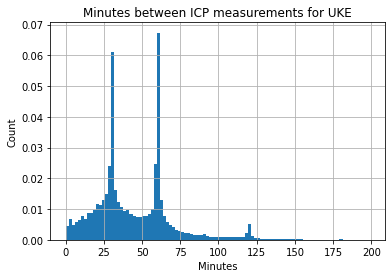

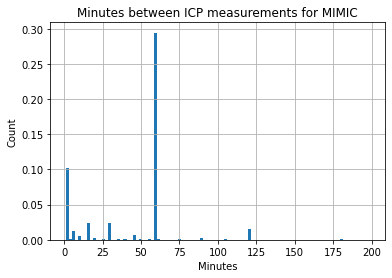

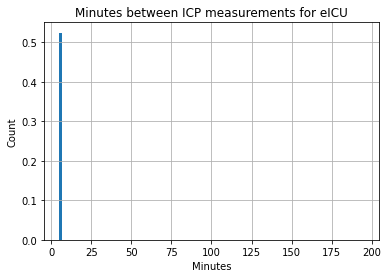

In [ ]:
# check distance between icp measurements per DB
for db in ["UKE", "MIMIC", "eICU"]:
    df_db = df_long[df_long["DB"] == db]
    
    plt.figure()
    diffs_db = df_db.groupby(["Pat_ID", "window_id"]).apply(lambda win: win[win["Maßnahme"] == "ICP_Vital"].sort_values("rel_time").rel_time.diff()).reset_index(drop=True)    
    diffs_db = diffs_db[diffs_db < 200]
    # make normalized histogram
    diffs_db.hist(bins=100, alpha=1.0, label=db, density=True)
    plt.xlabel("Minutes")
    plt.ylabel("Count")
    plt.title(f"Minutes between ICP measurements for {db}")
    #plt.yscale("log")
    #plt.legend()
    os.makedirs("figures", exist_ok=True)
    plt.savefig(f"figures/{db}_icp_diffs.pdf")

In [ ]:
diffs_db.value_counts()

5.0      2616211
10.0        1449
15.0         929
25.0         865
30.0         769
20.0         754
35.0         620
40.0         427
45.0         299
50.0         216
55.0         172
60.0         150
65.0         113
70.0          94
75.0          82
80.0          77
85.0          70
120.0         69
110.0         61
95.0          58
90.0          58
115.0         57
100.0         54
130.0         51
105.0         49
125.0         43
135.0         39
140.0         36
150.0         34
155.0         33
145.0         25
160.0         25
165.0         24
175.0         23
195.0         23
170.0         22
190.0         20
185.0         18
180.0         11
Name: rel_time, dtype: int64

In [ ]:
from typing import Tuple

import numba

minutes = 15

@numba.jit()
def create_dict(values: np.ndarray, rel_time: np.ndarray, measure_name: str, high_counts: Tuple[str], minutes: int):
    means = []
    stds = []
    mins = []
    maxs = []
    rel_times = []
    i = 0
    while i < len(values): 
        # add consequent measurements as long as they fit in time window
        # subtract remainder to make sure rel_times are fitted in the right time window
        current_rel_time = rel_time[i] - (rel_time[i] % minutes)  
        vals = []
        while i < len(values) and rel_time[i] < current_rel_time + minutes:
            vals.append(values[i])
            i += 1
        # summarize values
        vals = np.array(vals)
        means.append(np.mean(vals))
        rel_times.append(current_rel_time)
        # add detailed summary if it is a high count feature
        if measure_name in high_counts:
            stds.append(np.std(vals))
            mins.append(np.min(vals))
            maxs.append(np.max(vals))
    return means, stds, mins, maxs, rel_times


def summarize_measure(measure, high_counts, minutes):
    # get name and relevant columns
    measure_name = measure["Maßnahme"].iloc[0]
    rel_time = measure["rel_time"].to_numpy().astype(float)
    values = measure["Wert"].to_numpy().astype(float)
    # get lists
    means, stds, mins, maxs, rel_time = create_dict(values, rel_time, measure_name, high_counts, minutes)
    # create new, shorter df with same base stats (Pat_ID etc.)
    new_df = pd.DataFrame({"rel_time": rel_time, "Wert": means})
    new_df["Pat_ID"] = measure["Pat_ID"].iloc[0]
    new_df["Maßnahme"] = measure["Maßnahme"].iloc[0]
    new_df["Maßnahme_norm"] = measure["Maßnahme_norm"].iloc[0]
    new_df["DB"] = measure["DB"].iloc[0]
    new_df["window_id"] = measure["window_id"].iloc[0]
    if len(stds) > 0:
        # if we have additional stats for this feature, copy the df above, fill in other value and append it
        new_measures = {measure_name: means,
                        measure_name + "_std": stds,
                        measure_name + "_min": mins,
                        measure_name + "_max": maxs} 
        dfs = [new_df.copy() for key in new_measures]
        for df, key in zip(dfs, new_measures):
            df["Maßnahme"] = key
            df["Wert"] = new_measures[key]
        new_df = pd.concat(dfs, axis=0)
    return new_df
            
def summarize_patient(pat, high_counts, minutes):
    return pat.groupby("Maßnahme").apply(lambda measure: summarize_measure(measure, high_counts, minutes)).reset_index(drop=True)

df_long_summarized = df_long.groupby(["Pat_ID", "window_id"]).progress_apply(lambda pat: summarize_patient(pat.sort_values("rel_time", ascending=True), high_counts, minutes)).reset_index(drop=True)
# summarize per N minutes (5 min, 60 min) 
# take mean, min, max, std per Vital measure

  0%|          | 0/3764 [00:00<?, ?it/s]

/home/anton/.local/lib/python3.8/site-packages/numba/core/ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'high_counts' of function 'create_dict'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../tmp/ipykernel_2839263/1124370976.py", line 7:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [ ]:
print(df_long.groupby("DB").apply(lambda db: len(db[db["Maßnahme"] == "ICP_Vital"])))

DB
MIMIC     189574
UKE       368183
eICU     2626257
dtype: int64


In [ ]:
print(df_long_summarized.groupby("DB").apply(lambda db: len(db[db["Maßnahme"] == "ICP_Vital"])))

DB
MIMIC    150227
UKE      350785
eICU     881597
dtype: int64


In [ ]:
count = 0
for _ in df_long.groupby(["Pat_ID", "window_id"]):
    count += 1
print("Total windows: ", count)

Total windows:  3764


In [ ]:
df_long.DB

0             eICU
1             eICU
2             eICU
3             eICU
4             eICU
             ...  
108653404    MIMIC
108653405    MIMIC
108653406    MIMIC
108653407    MIMIC
108653408    MIMIC
Name: DB, Length: 108139570, dtype: object

In [ ]:
# norm med by maßnahme norm per db
meds = [feat for feat in df_long_summarized["Maßnahme"].unique() if "_Med" in feat]

meds
#def norm_group(group):
#    if group["Maßnahme"].iloc[0] in meds:
#        group["Wert"] = (group["Wert"] - group["Wert"].mean()) / group["Wert"].std()
#    return group
#df_long_normed_med = df_long_summarized.groupby("DB").apply(lambda db: db.groupby("Maßnahme_norm").apply(norm_group)).reset_index(drop=True)
#df_long = df_long.drop(columns=["Maßnahme_norm"])

# not done anymore to avoid information leakage from test to train and also to avoid merging meds of different strengths into one
# instead we now replace the Maßnahme col by Maßnahme_norm for all meds 
def replace_measure(measure):
    if measure["Maßnahme"].iloc[0] in meds:
        measure["Maßnahme"] = measure["Maßnahme_norm"] + "_Med"
    return measure
df_long_meds = df_long_summarized.groupby("Maßnahme").apply(lambda measure: replace_measure(measure)).reset_index(drop=True)

In [ ]:
meds_now = [feat for feat in df_long_meds["Maßnahme"].unique() if "_Med" in feat]

meds, meds_now, len(meds), len(meds_now)

(['Alpha Blocker_Med',
  'Narkotikum_Med',
  'Katecholamin_Med',
  'Opioid_Med',
  'Direkter Vasodilatator_Med',
  'Benzodiazepin_Med',
  'Barbiturat_Med'],
 ['Dexmedetomidine Inj 400 Mcg in Sodium Chloride 0.9% 100 ml (mcg/kg/hr)_Med',
  'Propofol (mcg/kg/min)_Med',
  'Dexmedetomidine Inj 400 Mcg in Dextrose 5% 100 ml (mcg/kg/hr)_Med',
  'Norepinephrine ()_Med',
  'Propofol (ml/hr)_Med',
  'Fentanyl (mcg/hr)_Med',
  'Dexmedetomidine (mcg/kg/hr)_Med',
  'Norepinephrine (mcg/min)_Med',
  'Fentanyl (mcg/kg/hr)_Med',
  'Phenylephrine (mcg/min)_Med',
  'Dopamine (ml/hr)_Med',
  'Nitroprusside (mcg/kg/min)_Med',
  'Lorazepam (mg/hr)_Med',
  'Morphine (mg/hr)_Med',
  'Midazolam (mg/hr)_Med',
  'Norepinephrine (ml/hr)_Med',
  'Fentanyl (ml/hr)_Med',
  'Midazolam (ml/hr)_Med',
  'Dexmedetomidine (ml/hr)_Med',
  'Phenylephrine (ml/hr)_Med',
  'Epinephrine (ml/hr)_Med',
  'Pentobarbital (ml/hr)_Med',
  'Dobutamine (ml/hr)_Med',
  'Hydromorphone IVF Infused (ml/hr)_Med',
  'Nitroglycerin (mcg/min

In [ ]:
#icp_long = df_long[df_long["Maßnahme"] == "ICP_Vital"]
#print(icp_long.groupby("DB").apply(len))
#icp_long_summ = df_long_summarized[df_long_summarized["Maßnahme"] == "ICP_Vital"]
#print(icp_long_summ.groupby("DB").apply(lambda x: len(x)))
#icp_long_med_normed = df_long_normed_med[df_long_normed_med["Maßnahme"] == "ICP_Vital"]
#print(icp_long_med_normed.groupby("DB").apply(lambda x: len(x)))

In [ ]:
# from long to wide
df = df_long_meds.pivot_table(index=["rel_time", "Pat_ID", "DB", "window_id"], columns="Maßnahme", values="Wert").reset_index()

In [ ]:
df

Maßnahme,rel_time,Pat_ID,DB,window_id,AF_Vital,AF_Vital_max,AF_Vital_min,AF_Vital_std,ALT_Labor,AST_Labor,...,mittl_Vital_min,mittl_Vital_std,norepinephrine Volume (ml) (ml/hr)_Med,pH_BGA,pankreasspez_Labor,sO2_BGA,syst_Vital,syst_Vital_max,syst_Vital_min,syst_Vital_std
0,0.0,141800,eICU,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,143881,eICU,0,NaN,NaN,NaN,NaN,24.0,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,145396,eICU,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,7.46,NaN,98.0,NaN,NaN,NaN,NaN
3,0.0,145603,eICU,0,NaN,NaN,NaN,NaN,NaN,NaN,...,82.0,0.942809,NaN,NaN,NaN,NaN,150.666667,156.0,140.0,7.542472
4,0.0,146291,eICU,0,19.666667,22.0,18.0,1.699673,NaN,NaN,...,105.0,23.442601,NaN,NaN,NaN,NaN,182.666667,226.0,131.0,39.228674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2564215,72180.0,3227651,eICU,1,10.666667,13.0,8.0,2.054805,NaN,NaN,...,93.0,10.473180,NaN,NaN,NaN,NaN,150.250000,152.0,148.0,1.479020
2564216,72195.0,3227651,eICU,1,11.333333,13.0,10.0,1.247219,NaN,NaN,...,107.0,3.559026,NaN,NaN,NaN,NaN,131.333333,135.0,125.0,4.496913
2564217,72210.0,3227651,eICU,1,11.000000,12.0,10.0,0.816497,NaN,NaN,...,114.0,0.942809,NaN,NaN,NaN,NaN,118.333333,120.0,117.0,1.247219
2564218,72225.0,3227651,eICU,1,12.666667,13.0,12.0,0.471405,NaN,NaN,...,104.0,4.189935,NaN,NaN,NaN,NaN,133.000000,142.0,118.0,10.677078


In [ ]:
df.to_csv(f"data/df_wide_{minutes}.csv", index=False)

In [ ]:
# Num ICP measurements per DB
print(len(df))
print(df.groupby("DB").apply(lambda x: len(x[~x["ICP_Vital"].isna()])))
print(df["ICP_Vital"].isna().mean())

2564220
DB
MIMIC    150227
UKE      350785
eICU     881597
dtype: int64
0.4608071850309256


In [ ]:
# fill in rows with NAN where we have no measurement at all

#@numba.jit()
def add_nan_rows(arr: np.ndarray, rel_time: np.ndarray, minutes: int):
    # check dist between all consecutive rel_times and create NaN array, which is added to list. Merge this list in the end
    num_feats = arr.shape[1]
    rows = []
    old_time = rel_time[0]
    for row, t in zip(arr, rel_time):
        #print(t)
        # check how many rows between old_time and current time have to be added
        num_rows = int(np.ceil((t - old_time) / minutes)) - 1
        if num_rows > 0:
            #print(num_rows)
            #num_rows_added.append(num_rows)
            new_rows = np.ones((num_rows, num_feats)) * np.nan
            rows.append(new_rows)
        rows.append(np.expand_dims(row, 0))
        old_time = t
    return np.concatenate(rows, axis=0)


num_rows_added = []
def unroll_patient(pat, minutes):
    # assumes a patient, sorted by rel_time
    # transform to numpy array and move to helper function
    rel_time = pat["rel_time"].to_numpy()
    db = pat["DB"].iloc[0]
    pat_id = pat["Pat_ID"].iloc[0]
    # drop DB and pat_id temporarily, as their type is str
    pat = pat.drop(columns=["DB", "Pat_ID"]).astype(np.float32)
    arr = pat.to_numpy()

    # get new_array that contains nan_rows where necessary
    #print("old array shape: ", pat.shape)
    new_array = add_nan_rows(arr, rel_time, minutes)
    num_rows_added.append(len(new_array) - len(arr))
    #print("new array shape: ", new_array.shape)
    # set Pat_ID, rel_time and col names correctly at end
    new_pat = pd.DataFrame(data=new_array, columns=pat.columns, index=np.arange(len(new_array)))
    new_pat["DB"] = db 
    new_pat["Pat_ID"] = pat_id
    # fill in rel_times
    start_time = pat["rel_time"].iloc[0]
    new_pat["rel_time"] = np.arange(start_time, start_time + len(new_pat) * minutes, minutes)
    return new_pat
    

df_filled = df.groupby(["Pat_ID", "window_id"]).progress_apply(lambda pat: unroll_patient(pat.sort_values("rel_time", ascending=True), minutes)).reset_index(drop=True)

  0%|          | 0/3764 [00:00<?, ?it/s]

In [ ]:
print("Rows added: ", sum(num_rows_added))

Rows added:  200933


Text(0.5, 0, 'Num consecutive missing steps')

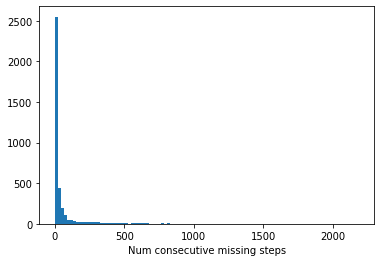

In [ ]:
import matplotlib.pyplot as plt
p = plt.hist(num_rows_added, bins=100)
plt.xlabel("Num consecutive missing steps")

In [ ]:
len(num_rows_added)

3764

In [ ]:
df_filled.to_csv(f"data/df_filled_{minutes}.csv", index=False)

In [ ]:
#df_filled = pd.read_csv("data/df_filled_60.csv")

In [ ]:
df_filled

Maßnahme,rel_time,window_id,AF_Vital,AF_Vital_max,AF_Vital_min,AF_Vital_std,ALT_Labor,AST_Labor,Albumin_Labor,Alk_Labor,...,norepinephrine Volume (ml) (ml/hr)_Med,pH_BGA,pankreasspez_Labor,sO2_BGA,syst_Vital,syst_Vital_max,syst_Vital_min,syst_Vital_std,DB,Pat_ID
0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,eICU,141800
1,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,eICU,141800
2,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,eICU,141800
3,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,eICU,141800
4,60.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7.45,NaN,98.0,NaN,NaN,NaN,NaN,eICU,141800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2765148,18000.0,0.0,23.0,23.0,23.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,166.0,166.0,166.0,0.0,MIMIC,99863_100749
2765149,18015.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MIMIC,99863_100749
2765150,18030.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MIMIC,99863_100749
2765151,18045.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MIMIC,99863_100749


In [ ]:
# fill med missing with 0
df_med_filled = df_filled.copy()
med_col_names = [col for col in df_med_filled.columns if "_Med" in col]
df_med_filled[med_col_names] = df_med_filled[med_col_names].fillna(0)

In [ ]:
# disabled for now as it reduces UKE performance a lot. Might be useful for better dataset transfer in the future
"""
# show values with highest std of NaNs between DBs
max_nan_frac_over_dbs = df_med_filled.groupby("DB").apply(lambda db: db.isna().mean()).std().sort_values().iloc[-10:]
max_nan_frac_over_dbs
# select highest ranking ones
drop_cols = ["PEEP_Vital", "Pmean_Vital", "Freq gesamt_Vital", "Ppeak_Vital", "FiO2_Vital", "Freq spontan_Vital"]
"""
pass

In [ ]:
# select measurements with at least 99.95% missingness
max_missing = df_med_filled.groupby("DB").apply(lambda db: db.isna().mean()).max()
max_drop = max_missing[max_missing > 0.9995]
drop_cols = list(max_drop.index)

In [ ]:
drop_cols

['Basophile_Labor',
 'Bili_BGA',
 'CK-MB_Labor',
 'CRP_Labor',
 'Cholesterin_Labor',
 'Eosinophile_Labor',
 'FCOHb_BGA',
 'FiO2_BGA',
 'LDH_Labor',
 'Lipase_Labor',
 'Lymphocyten_Labor',
 'Monocyten_Labor',
 'Neutrophile_Labor',
 'RASS_Vital',
 'TSH_Labor',
 'Triglyceride_Labor',
 'fT3_Labor',
 'fT4_Labor',
 'pankreasspez_Labor']

In [ ]:
# remove feature that have N% missing spots in at least one database
#threshold = 1 - (1 - 0.999) / (60 / minutes)  # make it such that it is 0.99 for 60 minutes and 0.999 for 5 minutes
#max_nan_frac_over_dbs = df_med_filled.groupby("DB").apply(lambda db: db.isna().mean()).max().sort_values()
#drop_cols = list(max_nan_frac_over_dbs[max_nan_frac_over_dbs > threshold].index)
df_drop_too_missing = df_med_filled.drop(columns=drop_cols)
print("Dropped: ", drop_cols, " - ", len(drop_cols))

Dropped:  ['Basophile_Labor', 'Bili_BGA', 'CK-MB_Labor', 'CRP_Labor', 'Cholesterin_Labor', 'Eosinophile_Labor', 'FCOHb_BGA', 'FiO2_BGA', 'LDH_Labor', 'Lipase_Labor', 'Lymphocyten_Labor', 'Monocyten_Labor', 'Neutrophile_Labor', 'RASS_Vital', 'TSH_Labor', 'Triglyceride_Labor', 'fT3_Labor', 'fT4_Labor', 'pankreasspez_Labor']  -  19


In [ ]:
# get patient data such as gender etc
df_static = pd.read_csv("data/Datenbank_Pat_ID.csv")
df_static = df_static[["Pat_ID", "Alter", "Diagnose_txt", "Geschlecht", "Größe", "Gewicht"]]
df_static = df_static.rename(columns={"Diagnose_txt": "Diagnose"})
# one-hot encode
df_static = pd.get_dummies(df_static, columns=["Diagnose", "Geschlecht"])
df_static = df_static.drop(columns=["Geschlecht_Weiblich"])
df_static = df_static.rename(columns={"Geschlecht_Männlich": "Geschlecht"})
# drop nan Pat_ID
df_static = df_static.dropna(subset=["Pat_ID"])

In [ ]:
# merge
df_drop_too_missing["Pat_ID"] = df_drop_too_missing["Pat_ID"].astype(int)
df_static["Pat_ID"] = df_static["Pat_ID"].astype(int)
df_large = pd.merge(df_drop_too_missing, df_static, on="Pat_ID", how="left")

In [ ]:
# one-hot-encode DB
df_large = pd.get_dummies(df_large, columns=["DB"])

In [ ]:
path = f"data/df_final_{minutes}.csv"
df_large.to_csv(path, index=False)
print("Saved to: ", path)

Saved to:  data/df_final_15.csv


In [ ]:
#df_large = pd.read_csv(path)

In [ ]:
#df_large.isna().mean().sort_values().iloc[-30:]

In [ ]:
df_large

,rel_time,window_id,AF_Vital,AF_Vital_max,AF_Vital_min,AF_Vital_std,ALT_Labor,AST_Labor,Albumin_Labor,Alk_Labor,...,Diagnose_ICH,Diagnose_MISC,Diagnose_SAH,Diagnose_Stroke,Diagnose_TBI,Diagnose_Tumor,Geschlecht,DB_MIMIC,DB_UKE,DB_eICU
0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,1
1,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,1
2,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,1
3,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,1
4,60.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2765148,18000.0,0.0,23.0,23.0,23.0,0.0,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,1,1,0,0
2765149,18015.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,1,1,0,0
2765150,18030.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,1,1,0,0
2765151,18045.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,1,1,0,0


In [ ]:
# measure how often meds are non-zero
for db in ["DB_MIMIC", "DB_MIMIC", "DB_eICU"]:
    db_df = df_large[df_large[db] == 1]
    sorted_meds = (db_df[med_col_names] == 0).mean().sort_values()
    print(db)
    print(sorted_meds.iloc[:10])
    print()
    
    all_zero_cols = list(sorted_meds[sorted_meds == 0].index)
    # per DB, set med values to NaN if they are all 0
    df_large.loc[df_large[db] == 1, all_zero_cols] = np.nan

DB_MIMIC
Propofol_Med                  0.617366
Neosynephrine_Med             0.866824
Phenylephrine_Med             0.918715
Nitroprusside_Med             0.922927
Labetolol_Med                 0.947619
Fentanyl_Med                  0.950881
Fentanyl (Concentrate)_Med    0.962166
Norepinephrine_Med            0.985427
Pentobarbital_Med             0.986555
Midazolam (Versed)_Med        0.987424
dtype: float64

DB_MIMIC
Propofol_Med                  0.617366
Neosynephrine_Med             0.866824
Phenylephrine_Med             0.918715
Nitroprusside_Med             0.922927
Labetolol_Med                 0.947619
Fentanyl_Med                  0.950881
Fentanyl (Concentrate)_Med    0.962166
Norepinephrine_Med            0.985427
Pentobarbital_Med             0.986555
Midazolam (Versed)_Med        0.987424
dtype: float64

DB_eICU
Propofol (ml/hr)_Med               0.932888
Propofol (mcg/kg/min)_Med          0.934252
Fentanyl (mcg/hr)_Med              0.944336
Propofol ()_Med               

In [ ]:
df_large.isna().mean().sort_values()

rel_time                          0.000000
Nembutal (mg/kg/hr)_Med           0.000000
Neosynephrine_Med                 0.000000
Nitroglycerin (mcg/kg/min)_Med    0.000000
Nitroglycerin (mcg/min)_Med       0.000000
                                    ...   
AST_Labor                         0.997107
Albumin_Labor                     0.997309
Alk_Labor                         0.998080
CK_Labor                          0.998198
Troponin_Labor                    0.999354
Length: 198, dtype: float64

In [ ]:
df_large[df_large["DB_UKE"] == 0].isna().mean().sort_values()

rel_time                          0.000000
Nembutal (mg/kg/hr)_Med           0.000000
Neosynephrine_Med                 0.000000
Nitroglycerin (mcg/kg/min)_Med    0.000000
Nitroglycerin (mcg/min)_Med       0.000000
                                    ...   
AST_Labor                         0.997198
ALT_Labor                         0.997222
Alk_Labor                         0.997269
CK_Labor                          0.998706
Troponin_Labor                    0.999258
Length: 198, dtype: float64

In [ ]:
# remove correlated feats per database. Set dropped values to NaN
df_corr = df_large.copy()

threshold = 0.90

for db in ["DB_UKE", "DB_MIMIC", "DB_eICU"]:
    db_df = df_corr[df_corr[db] == 1]
    corr_matrix = db_df.corr()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print(db)
    print(to_drop)
    print()
    df_corr.loc[df_corr[db] == 1, to_drop] = np.nan

# drop columns that are now completely NaN
# first print them
print(df_corr.isna().mean().sort_values().iloc[-10:])
# then drop them
df_corr = df_corr.dropna(axis=1, how="all")

/tmp/ipykernel_2839263/1891787338.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


DB_UKE
['AF_Vital_max', 'AF_Vital_min', 'CPP_Vital_max', 'CPP_Vital_min', 'Freq gesamt_Vital', 'GCS_total_Vital', 'HF_Vital_max', 'HF_Vital_min', 'Hk_Labor', 'ICP_Vital_max', 'ICP_Vital_min', 'SBE_BGA', 'SpO2_Vital_max', 'SpO2_Vital_min', 'Temp_Vital_max', 'Temp_Vital_min', 'diast_Vital_max', 'diast_Vital_min', 'mittl_Vital_max', 'mittl_Vital_min', 'syst_Vital_max', 'syst_Vital_min']



/tmp/ipykernel_2839263/1891787338.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


DB_MIMIC
['AF_Vital_max', 'AF_Vital_min', 'CPP_Vital_max', 'CPP_Vital_min', 'HF_Vital_max', 'HF_Vital_min', 'Hk_Labor', 'ICP_Vital_max', 'ICP_Vital_min', 'SpO2_Vital_max', 'SpO2_Vital_min', 'Temp_Vital_max', 'Temp_Vital_min', 'diast_Vital_max', 'diast_Vital_min', 'mittl_Vital_max', 'syst_Vital_max', 'syst_Vital_min']



/tmp/ipykernel_2839263/1891787338.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


DB_eICU
['AF_Vital_max', 'AF_Vital_min', 'AST_Labor', 'CPP_Vital_max', 'CPP_Vital_min', 'HF_Vital_max', 'HF_Vital_min', 'Hb_BGA_BGA', 'Hk_Labor', 'ICP_Vital_max', 'ICP_Vital_min', 'Na_BGA', 'SBE_BGA', 'SpO2_Vital_max', 'SpO2_Vital_min', 'TZ_Labor', 'Temp_Vital_max', 'Temp_Vital_min', 'diast_Vital_max', 'diast_Vital_min', 'mittl_Vital_max', 'mittl_Vital_min', 'syst_Vital_max', 'syst_Vital_min']

SpO2_Vital_max     1.0
SpO2_Vital_min     1.0
diast_Vital_min    1.0
CPP_Vital_min      1.0
syst_Vital_min     1.0
syst_Vital_max     1.0
HF_Vital_max       1.0
CPP_Vital_max      1.0
Temp_Vital_min     1.0
diast_Vital_max    1.0
dtype: float64


In [ ]:
# set feats completely to NaN per DB that now have too many NaNs
for db in ["DB_UKE", "DB_MIMIC", "DB_eICU"]:
    db_df = df_corr[df_corr[db] == 1]
    missing_per_col = db_df.isna().mean().sort_values()
    # ignore completely missing ones
    missing_per_col = missing_per_col[missing_per_col < 1.0]
    print(db)
    print(missing_per_col.iloc[-5:])
    print()
    drop_cols = list(missing_per_col[missing_per_col > 0.999].index)
    df_corr.loc[df_corr[db] == 1, drop_cols] = np.nan

DB_UKE
CK_Labor            0.997492
Albumin_Labor       0.997618
Leukocyten_Labor    0.997773
Alk_Labor           0.999208
Troponin_Labor      0.999487
dtype: float64

DB_MIMIC
Alk_Labor             0.997786
CK_Labor              0.997940
Troponin_Labor        0.999234
Leukocyten_Labor      0.999263
Erythrocyten_Labor    0.999373
dtype: float64

DB_eICU
Alk_Labor         0.996935
aPTT_Labor        0.997362
Lac_BGA           0.997645
CK_Labor          0.999202
Troponin_Labor    0.999274
dtype: float64



In [ ]:
def add_split_idcs(df, test_size=0.1):
    pat_ids = df["Pat_ID"].unique()
    seq_list = [df[df["Pat_ID"] == pat_id] for pat_id in pat_ids]
    dev_data, test_data, dev_idcs, test_idcs = make_split(seq_list, test_size=test_size)
    #df[dev_idcs]["split"] = "dev"
    #df.loc[test_idcs, "split"] = "test"
    train_data, val_data, train_idcs, val_idcs = make_split(dev_data, test_size=test_size)
    mapped_train_idcs = dev_idcs[train_idcs]
    mapped_val_idcs = dev_idcs[val_idcs]
    
    # map idcs to pat_ids
    train_pat_ids = set(pat_ids[mapped_train_idcs])
    val_pat_ids = set(pat_ids[mapped_val_idcs])
    test_pat_ids = set(pat_ids[test_idcs])
    
    # set column in original df according to idcs
    def assign_split_name(pat_id):
        if pat_id in train_pat_ids:
            return "train"
        elif pat_id in val_pat_ids:
            return "val"
        else:
            return "test"
    df["split"] = df["Pat_ID"].apply(assign_split_name)
    
    return df

In [ ]:
import os

from data_utils import make_split
db_cols = [col for col in df_corr.columns if "DB_" in col]
for db_name in db_cols:
    print(db_name)
    db_df = df_corr[df_corr[db_name] == 1].drop(columns=db_cols)
    # drop columns that are completely NaN
    db_df = db_df.dropna(axis=1, how="all")
    # drop columns that are completely zero
    mean_zeros = (db_df == 0).mean()
    db_df = db_df[list(mean_zeros[mean_zeros < 1.0].index)]
    # make splits
    db_df = add_split_idcs(db_df, test_size=0.2)
    # save it
    save_path = f"data/{db_name}_{minutes}_final_df.pkl"
    os.makedirs("data/", exist_ok=True)
    db_df.to_pickle(save_path)
    db_df.to_parquet(f"data/{db_name}_{minutes}_final_df.parquet")

DB_MIMIC
DB_UKE
DB_eICU


In [ ]:
save_path

'data/DB_eICU_15_final_df.pkl'

In [ ]:
(db_df["split"] == "train").sum()

636190

In [ ]:
list(db_df.columns)

['rel_time',
 'window_id',
 'AF_Vital',
 'AF_Vital_std',
 'ALT_Labor',
 'Albumin_Labor',
 'Alk_Labor',
 'Ativan_Med',
 'CPP_Vital',
 'CPP_Vital_std',
 'Ca_BGA',
 'Cl_BGA',
 'Clonidin (Paracefan) Amp._Med',
 'Dexmedetomidine (Precedex)_Med',
 'Dexmedetomidine (mcg/kg/hr) (mcg/kg/hr)_Med',
 'Dexmedetomidine (mcg/kg/hr)_Med',
 'Dexmedetomidine (ml/hr)_Med',
 'Dexmedetomidine Inj 400 Mcg in Dextrose 5% 100 ml (mcg/kg/hr)_Med',
 'Dexmedetomidine Inj 400 Mcg in Sodium Chloride 0.9% 100 ml (mcg/kg/hr)_Med',
 'Dexmedetomidine(Precedex) 400 mcg Sodium Chloride 0.9% 100 ml (mcg/kg/hr)_Med',
 'Dihydralazin (Nepresol) Amp._Med',
 'Dihydralazin (Nepresol)_Med',
 'Dilaudid_Med',
 'Dobutamine (mcg/kg/min)_Med',
 'Dobutamine (ml/hr)_Med',
 'Dobutamine_Med',
 'Dopamine ()_Med',
 'Dopamine (mcg/kg/min)_Med',
 'Dopamine (ml/hr)_Med',
 'Dopamine_Med',
 'EVB_Labor',
 'Epinephrine (mg/kg/min)_Med',
 'Epinephrine (ml/hr)_Med',
 'Epinephrine_Med',
 'Erythrocyten_Labor',
 'FentaNYL (Sublimaze) 2500 mcg Sodium 

<AxesSubplot:>

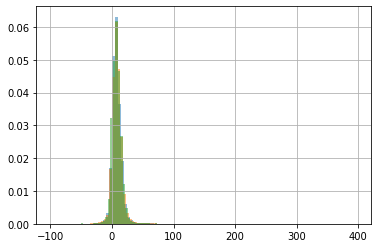

In [ ]:
# check icp distributions
db_df[db_df["split"] == "train"]["ICP_Vital"].hist(bins=100, density=True, alpha=0.5)
db_df[db_df["split"] == "val"]["ICP_Vital"].hist(bins=100, density=True, alpha=0.5)
db_df[db_df["split"] == "test"]["ICP_Vital"].hist(bins=100, density=True, alpha=0.5)

<AxesSubplot:>

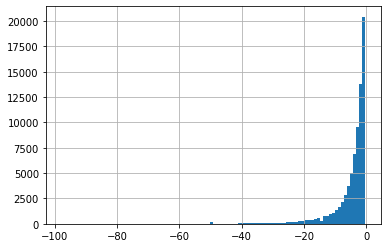

In [ ]:
vals = db_df["ICP_Vital"]

vals[vals < 0].hist(bins=100)

In [ ]:
vals.quantile(0.001)

-30.33333396911621

In [ ]:
len(vals)

976832

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# check distributions
p = uke_df.hist(bins=100, figsize=(15, 15))
plt.tight_layout()

NameError: name 'uke_df' is not defined

In [ ]:
from sklearn.preprocessing import PowerTransformer

transform = PowerTransformer(method='yeo-johnson', standardize=True)

In [ ]:
uke_df = df_large[df_large["DB_UKE"] == 1]

In [ ]:
uke_arr = uke_df.to_numpy()

In [ ]:
transform.fit(uke_arr)

In [ ]:
np.round(transform.lambdas_, 1)

In [ ]:
transformed_arr = transform.transform(uke_arr)

In [ ]:
lambdas_ = transform.lambdas_
mask = np.abs(lambdas_) > 5
print(lambdas_[mask])

In [ ]:
transformed_df = pd.DataFrame(transformed_arr, columns=df_large.columns)#, index=df_large.index)

In [ ]:
feat = "sO2_BGA"

In [ ]:
idx = list(transformed_df.columns).index(feat)
lambdas_[idx]

In [ ]:
uke_df[feat].describe()

In [ ]:
transformed_df[feat].describe()

In [ ]:
uke_df[feat].unique()

In [ ]:
transformed_df[feat].unique()

In [ ]:
uke_df[feat].hist(bins=100)

In [ ]:
transformed_df[feat].hist(bins=100)

In [ ]:
import numba
import numpy as np

@numba.jit()
def ema_fill(pat: np.ndarray, ema_val: float, mean: np.ndarray):
    # init ema
    ema = np.ones_like(pat[0]) * pat[0]
    ema[np.isnan(ema)] = mean[np.isnan(ema)]
    # run ema
    ema_steps = np.ones_like(pat)
    for i, pat_step in enumerate(pat):
        pat_step[np.isnan(pat_step)] = 0
        ema = ema_val * ema + (1 - ema_val) * pat_step
        ema_steps[i] = ema.copy()
    return ema_steps

In [ ]:
mean = uke_df.mean().to_numpy()

In [ ]:
uke_filled = uke_df.groupby("Pat_ID").apply(lambda pat: pd.DataFrame(ema_fill(pat.sort_values("rel_time").to_numpy(), 0.9, mean), columns=pat.columns))

In [ ]:
def four_parts(df):
    leng = len(df)
    first = df.iloc[0: leng // 4].mean()
    second = df.iloc[leng // 4: leng // 2].mean()
    third = df.iloc[leng // 2: leng * 3 // 4].mean()
    fourth = df.iloc[leng * 3 // 4:].mean()
    all_parts = [first, second, third, fourth]
    return pd.DataFrame(all_parts, columns=df.columns)

In [ ]:
umap_arr_red = umap_norm.reset_index(drop=True).groupby("Pat_ID").apply(four_parts).reset_index(drop=True).dropna()

In [ ]:
umap_arr_dropped = umap_arr_red.drop(columns=["DB_MIMIC", "DB_UKE", "DB_eICU", "Pat_ID", "ICP_Vital"]).to_numpy()

In [ ]:
from sklearn.preprocessing import PowerTransformer

def apply_yeo(df, thresh=50, lambs=None):
    transform = PowerTransformer(method='yeo-johnson', standardize=False)
    drop_cols = ["DB_MIMIC", "DB_UKE", "DB_eICU", "Pat_ID", "ICP_Vital", "rel_time"]
    dropped = df.drop(columns=drop_cols)
    arr = dropped.to_numpy()
    if lambs is None:
        # apply yeo
        transform.fit(arr)
        lambs = transform.lambdas_ 
        mask = np.abs(lambs) > thresh
        print(df["DB_MIMIC"].sum(), df["DB_UKE"].sum(), df["DB_eICU"].sum())
        print(mask.sum())
        #print(pd.Series(np.round(lambs, 1), index=dropped.columns).sort_values(np.abs(lambs)))
        print(np.round(lambs, 1))
        print()
        lambs[mask] = 1
    transform.lambdas_ = lambs
    trans_arr = transform.transform(arr)
    # merge back
    df = pd.concat([pd.DataFrame(trans_arr, columns=dropped.columns), df[drop_cols]], axis=1)
    return df, lambs

In [ ]:
def create_umap_df(df, yeo=False, lambs=None, mean=None, std=None, thresh=10):
    # apply yeo
    if yeo:
        df, _ = apply_yeo(df, lambs=lambs, thresh=thresh)
    # calc median
    median = df.median().to_numpy()
    # fill using ema
    df_filled = df.groupby("Pat_ID").apply(lambda pat: pd.DataFrame(ema_fill(pat.sort_values("rel_time").to_numpy(), 0.9, median), columns=pat.columns)).reset_index(drop=True)
    # calc mean
    if mean is None:
        mean = df_filled.mean()
        std = df_filled.std()
        mean[std == 0] = 0
        std[std == 0] = 1
    #norm
    df_norm = (df_filled - mean) / std
    # average over four regions per Pat
    df_red = df_norm.groupby("Pat_ID").apply(four_parts).reset_index(drop=True).dropna()
    return df_red

In [ ]:
yeo = False
use_train_stats = False
thresh = 10

lambs = None
mean = None
std = None
    
if use_train_stats:
    train_df = df_large[df_large["DB_UKE"] == 1]
    if yeo:
        # calc lambdas for train dataset
        #train_df_filled = train_df.groupby("Pat_ID").apply(lambda pat: pd.DataFrame(ema_fill(pat.astype(float).sort_values("rel_time").to_numpy(), 0.9, train_df.median()), columns=pat.columns)).reset_index(drop=True)
        train_df, lambs = apply_yeo(train_df, thresh=thresh)
         # calc median
        median = train_df.median().to_numpy()
        # fill using ema
        train_df = train_df.groupby("Pat_ID").apply(lambda pat: pd.DataFrame(ema_fill(pat.sort_values("rel_time").to_numpy(), 0.9, median), columns=pat.columns)).reset_index(drop=True)
    
    # calc mean
    mean = train_df.mean().to_numpy()
    std = train_df.std()
    mean[std == 0] = 0
    std[std == 0] = 1


grouper = df_large["DB_UKE"] * 1 + df_large["DB_MIMIC"] * 2 + df_large["DB_eICU"] * 3
df_red = df_large.groupby(grouper).apply(lambda db: create_umap_df(db, yeo=yeo, lambs=lambs, mean=mean, std=std, thresh=thresh))
#df_red = transformed_df.groupby(grouper).apply(create_umap_df)

In [ ]:
if std is not None:
    std.sort_values()

In [ ]:
db_values = df_red["DB_UKE"] * 1 + df_red["DB_MIMIC"] * 2 + df_red["DB_eICU"] * 3
db_values[db_values == 1] = "UKE"
db_values[db_values == 2] = "MIMIC"
db_values[db_values == 3] = "eICU"

In [ ]:
# drop some cols and to numpy
drop_cols = ["DB_MIMIC", "DB_UKE", "DB_eICU", "Pat_ID", "ICP_Vital"]
#drop_cols.extend([col for col in df_red.columns if "_Med" in col])
#drop_cols.extend([col for col in df_red.columns if "Diagnose" in col])
#drop_cols.extend([col for col in df_red.columns if "BGA" in col])
#drop_cols.extend([col for col in df_red.columns if "Labor" in col])
#drop_cols.extend([col for col in df_red.columns if "Vital" in col])

#print(drop_cols)
dropped = df_red.drop(columns=drop_cols)
#print(dropped.columns)
arr = dropped.to_numpy()

In [ ]:
df_used.groupby(grouper).apply(lambda db: db["Cl_BGA"].mean())

In [ ]:
df_used.groupby(grouper).apply(lambda db: db["Cl_BGA"].std())

In [ ]:
dropped.groupby(db_values).apply(lambda db: db["Cl_BGA"].std())

In [ ]:
dropped.groupby(db_values).apply(lambda db: db["Cl_BGA"].mean())

In [ ]:
dropped["Cl_BGA"].std()

In [ ]:
from umap import UMAP
import umap.plot

umapper = UMAP(n_components=2, n_neighbors=15)
umapped_arr = umapper.fit_transform(arr)

In [ ]:
from sklearn.decomposition import PCA
mapper = PCA()

pca_arr = mapper.fit_transform(arr)
pca_arr.shape

In [ ]:
colors = db_values.copy()
colors[colors=="UKE"] = "red"
colors[colors=="MIMIC"] = "blue"
colors[colors=="eICU"] = "green"

colors = df_red["DB_UKE"]
plt.figure(figsize=(15, 7))
plt.scatter(pca_arr[:, 0], pca_arr[:, 1], c=colors, s=1.5)

In [ ]:
plt.plot(mapper.explained_variance_)

In [ ]:
comp_idx = 0
plt.bar(range(len(mapper.components_[comp_idx])), mapper.components_[comp_idx])
print(mapper.components_[comp_idx].sum())

In [ ]:
max_comp_idx = np.argmax(mapper.components_[comp_idx])
print(max_comp_idx)
print(dropped.columns[max_comp_idx])

In [ ]:
dropped.groupby(db_values).apply(lambda x: x["Temp_Vital"].std())

In [ ]:
#help(UMAP)

In [ ]:
#umap.plot.points(umapper, theme="fire", values=df_red["Pupille re_Vital"])

In [ ]:
umap.plot.points(umapper, theme="fire", values=df_red["Phosphat_Labor"])

In [ ]:
# yeo all
umap.plot.points(umapper, theme="fire", labels=db_values)

In [ ]:
umap.plot.points(umapper, theme="fire", labels=db_values)

In [ ]:
# yeo all
umap.plot.points(umapper, theme="fire", labels=db_values)

In [ ]:
# all
umap.plot.points(umapper, theme="fire", labels=db_values)

In [ ]:
# all yeo
umap.plot.points(umapper, theme="fire", labels=db_values)

In [ ]:
# only static
umap.plot.points(umapper, theme="fire", labels=db_values)

In [ ]:
# only vital
umap.plot.points(umapper, theme="fire", labels=db_values)

In [ ]:
# no med + no diag
umap.plot.points(umapper, theme="fire", labels=db_values)

In [ ]:
# no med
umap.plot.points(umapper, theme="fire", labels=db_values)

In [ ]:
umap.plot.points(umapper, theme="fire", labels=db_values)

In [ ]:
list(transformed_df.columns).index("Na_BGA")

In [ ]:
p = transformed_df.loc[:, mask].hist(figsize=(13, 13), bins=100)

In [ ]:
# find stds of 0
transformed_df.loc[:, transformed_df.std() == 0]

In [ ]:
transformed_df["sO2_BGA"].describe()

In [ ]:
np.quantile(transformed_df["sO2_BGA"].dropna(), 0.9999)

In [ ]:
np.quantile(df_large["sO2_BGA"].dropna(), 0.99)

In [ ]:
df_large["sO2_BGA"].describe()

In [ ]:
transformed_df.max()[transformed_df.max() > 5]

In [ ]:
transformed_df.loc[:, mask]

In [ ]:
transformed_df["Na_BGA"].hist(bins=100)
transformed_df["Na_BGA"].describe()

In [ ]:
p = transformed_df.hist(bins=100, figsize=(15, 15))
plt.tight_layout()

In [ ]:
(~df_large["ICP_Vital"].isna()).sum()

In [ ]:
(~df_large["ICP_Vital"].isna()).sum()

In [ ]:
len(df_large)

In [ ]:
(~df_large[df_large["DB_MIMIC"] == 1]["ICP_Vital"].isna()).sum()

In [ ]:
len(df_large[df_large["DB_MIMIC"] == 1]["ICP_Vital"])

In [ ]:
# 5 min: 3093093 ICP_Vital non_nans. 154014 in MIMIC
# len total: xxx. MIMIC: 2118712

In [ ]:
# 60 min: 585353 ICP VItal non_nans in total. 128303 in MIMIC
# total steps: 735951. MIMIC: 177102

In [ ]:
test_df["Diagnose_Tumor"].isna().mean()

In [ ]:
test_df["Alter"].isna().mean()

In [ ]:
test_df = pd.read_csv("data/df_final_5.csv")

In [ ]:
len(test_df[test_df["DB_MIMIC"] == 1]["ICP_Vital"])

In [ ]:
(~test_df[test_df["DB_MIMIC"] == 1]["ICP_Vital"].isna()).sum()

In [ ]:
(~df_large[df_large["DB_MIMIC"] == 1]["ICP_Vital"].isna()).sum()

In [ ]:
df_large[df_large["DB_MIMIC"] == 1]["ICP_Vital"].hist(bins=100)

In [ ]:
pat_ids = []
for db in df_long["DB"].unique():
    subset = df_long[df_long["DB"] == db]
    ids = subset["Pat_ID"].unique()
    pat_ids.append(ids)

In [ ]:
id_dict = {}
for id_ in pat_ids[0]:
    id_dict[id_] = 1
    

In [ ]:
for id_ in pat_ids[1]:
    if id_ in id_dict:
        print(id_, "is duplicate!")
        id_dict[id_] = 1

In [ ]:
for id_ in pat_ids[2]:
    if id_ in id_dict:
        print(id_, "is duplicate!")
        id_dict[id_] = 1

In [ ]:
np.isinf(df_large.to_numpy()).sum()

In [ ]:
# check specific data
clinic = df_large[df_large["DB_UKE"] == 1]
pat_ids = clinic["Pat_ID"].unique()

In [ ]:
len(pat_ids)

In [ ]:
clinic["ICP_Vital"].isna().mean()

In [ ]:
pat_idx = -500

pat_id = pat_ids[pat_idx]
pat = clinic[clinic["Pat_ID"] == pat_id]

In [ ]:
pat.plot.scatter(x="rel_time", y="ICP_Vital")
pat.plot(x="rel_time", y="ICP_Vital")

In [ ]:
#pat["HF_Vital"].plot()

In [ ]:
uke = df_long[df_long["DB"] == "UKE"]

In [ ]:
uke[uke["Maßnahme_norm"] == "FiO2"]

In [ ]:
nan_frac_per_db = df_filled.groupby("DB").apply(lambda: db.isna().mean())

In [ ]:
nan_frac_per_db

In [ ]:
for col in df_filled.columns:
    nan_means = df_filled.groupby("DB").apply(lambda db: db[col].isna().mean())
    print(col)
    print(nan_means)
    print()
    if max(nan_means) > 0.99:
        print("Drop: ", col)

In [ ]:
df_filled.groupby("DB").apply(lambda db: db["FiO2_BGA"].mean())

In [ ]:
df_filled.groupby("DB").apply(lambda db: db["FiO2_Vital"].mean())

In [ ]:
df_filled.groupby("DB").apply(lambda db: db["FiO2_Vital"].std())

In [ ]:
df_large["FiO2_BGA"]

In [ ]:
# FiO2 does not exist in UKE